Import all necessary packages and set figure parameters for graphs. 

In [1]:
import numpy as np  # Fast C++ arrays
import matplotlib.pyplot as plt  # Main visualisation package
import seaborn as sns  # Extension for visualization

from scipy.stats import beta, norm, skewnorm, ttest_ind  # Distribution functions and T-test
from scipy.interpolate import interp1d  # Interpolation function
from scipy.integrate import quad # Numerical integration function

# Adjust the size of the figure
fig_size = [8, 6]  
plt.rcParams["figure.figsize"] = fig_size
sns.set(color_codes=True)

Define a vector with the number of samples for the test as the argument. The p-value of the t-test will be counted n times for the number of samples and the percentage of significance will be calculated as the function value.

$\textrm{percentage of significance} = f(\textrm{number of samples})$

In [2]:
n_samples_array = np.arange(2, 100, 2)

Further, classes and functions are defined that will be used in further calculations.

Bimodal distribution consisting of two normal distributions. Given a finite set of cumulative distribution functions $P_1(x), …, P_n(x)$ and weights $\omega_1, …, \omega_n$ such that $\omega_i ≥ 0$ and $\sum \omega_i = 1$, the mixture distribution can be represented by writing the distribution function, F, as a sum: $F(x)=\sum^{n}_{i=1}\omega_{i}F(x)_{i}$

The expected value $E[H(X)]$ of any mixed distribution function $H(X)$ can be calculated according to the following formula: $E[H(X)]=\sum^{n}_{i=1}\omega_{i}H(X_{i})$

In [3]:
class Bimodal_norm():
    """
    Bimodal distribution consisting of two normal distributions.
    """
    def __init__(self, mu1=2, sigma1=1, coef1=0.5, mu2=-2, sigma2=1):
        self.mu1 = mu1
        self.sigma1 = sigma1
        self.coef1 = coef1
        self.mu2 = mu2
        self.sigma2 = sigma2
        self.x = np.linspace(-15, 15, 1000)
        
        cdf = self.coef1*norm.cdf(self.x, loc=self.mu1, scale=self.sigma1) + 
        (1-self.coef1)*norm.cdf(self.x, loc=self.mu2, scale=self.sigma2)
        self.mean = self.coef1*norm.mean(loc=self.mu1, scale=self.sigma1) + 
        (1-self.coef1)*norm.mean(loc=self.mu2, scale=self.sigma2)
        self.cdf = interp1d(self.x, cdf)
        self.ppf = interp1d(cdf, self.x)        
        self.pdf = interp1d(self.x, np.gradient(self.cdf(self.x)))

def prepare_skewnorm_quantile(mu, sigma, alpha):
    """
    Prepares the skewed normal distribution quantile function by interpolating several values. 
    """
    uniform_values = np.linspace(0.01, 0.99, 10)
    percent_point = skewnorm.ppf(uniform_values, alpha, loc=mu, scale=sigma)
    return interp1d(uniform_values, percent_point, kind="cubic")

def count_significance_frequency(n, model):
    """
    Counts the value of the function for the main graph. 
    In this case, the test compares the distribution function with itself.
    """
    p_values = np.array([ttest_ind(
        model(np.random.uniform(0.01, 0.99, n)),
        model(np.random.uniform(0.01, 0.99, n))
    )[1] for _ in range(500)])
    return (len(p_values[p_values < 0.05])/len(p_values))*100

def count_significance_frequency_2(n, model1, model2):
    """
    Counts the value of the function for the main graph, taking the sample size as an argument. 
    In this case, the test compares the distribution function with another function.
    """
    p_values = np.array([ttest_ind(
        model1(np.random.uniform(0.01, 0.99, n)),
        model2(np.random.uniform(0.01, 0.99, n))
    )[1] for _ in range(500)])
    return (len(p_values[p_values < 0.05])/len(p_values))*100

def prepare_xy(model1, model2=None):
    """
    Applies count_significance_frequency or count_significance_frequency_2 function 
    for all sample sizes.
    """
    if model2 is None:
        return n_samples_array, np.array([count_significance_frequency(n, model1) for n in n_samples_array])
    else:
        return n_samples_array, np.array([count_significance_frequency_2(n, model1, model2) for n in n_samples_array])

Parameters for four different distribution functions are configured.

In [6]:
mu = 0
sigma = 1
alpha = 4
a = 0.5
b = 0.5

binorm = Bimodal_norm()

models = [
    lambda x: norm.ppf(x, loc=mu, scale=sigma),  # normal distribution model
    prepare_skewnorm_quantile(mu, sigma, alpha),  # skewed-normal distribution model
    lambda x: beta.ppf(x, a=b, b=b, loc=mu, scale=sigma),  # distribution model
    lambda x: binorm.ppf(x)  # distribution model 
]

Then four different distribution functions are compared to themselves.

In [7]:
df = np.zeros([len(models), 2, n_samples_array.shape[0]])

for i in range(len(models)):
    x, y = prepare_xy(models[i])
    df[i, 0, :] = x
    df[i, 1, :] = y

The first graph shows the entire scale of percentages from zero to one hundred. On the second scale, it is reduced from zero to ten.

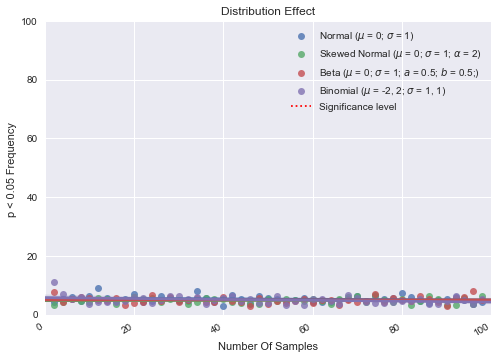

In [18]:
ax = sns.regplot(df[0, 0, :], df[0, 1, :], label="Normal ($\mu$ = 0; $\sigma$ = 1)")
ax1 = sns.regplot(df[1, 0, :], df[1, 1, :], label="Skewed Normal ($\mu$ = 0; $\sigma$ = 1; $\\alpha$ = 2)")
ax2 = sns.regplot(df[2, 0, :], df[2, 1, :], label="Beta ($\mu$ = 0; $\sigma$ = 1; $a$ = 0.5; $b$ = 0.5;)")
ax3 = sns.regplot(df[3, 0, :], df[3, 1, :], label="Binomial ($\mu$ = -2, 2; $\sigma$ = 1, 1)")
ax4 = plt.hlines(y=5, xmin=0, xmax=100, color='red', label="Significance level", linestyles="dotted")

ax.legend()
ax.set_title("Distribution Effect")
ax.set_xlabel("Number Of Samples")
ax.set_ylabel("p < 0.05 Frequency ")
plt.axis([0, 100, 0, 100])
plt.gcf().autofmt_xdate()
plt.show()

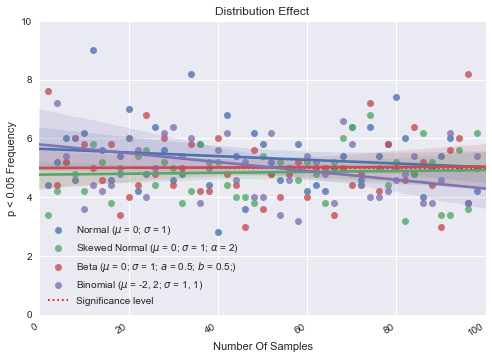

In [17]:
ax = sns.regplot(df[0, 0, :], df[0, 1, :], label="Normal ($\mu$ = 0; $\sigma$ = 1)")
ax1 = sns.regplot(df[1, 0, :], df[1, 1, :], label="Skewed Normal ($\mu$ = 0; $\sigma$ = 1; $\\alpha$ = 2)")
ax2 = sns.regplot(df[2, 0, :], df[2, 1, :], label="Beta ($\mu$ = 0; $\sigma$ = 1; $a$ = 0.5; $b$ = 0.5;)")
ax3 = sns.regplot(df[3, 0, :], df[3, 1, :], label="Binomial ($\mu$ = -2, 2; $\sigma$ = 1, 1)")
ax4 = plt.hlines(y=5, xmin=0, xmax=100, color='red', label="Significance level", linestyles="dotted")

ax.legend()
ax.set_title("Distribution Effect")
ax.set_xlabel("Number Of Samples")
ax.set_ylabel("p < 0.05 Frequency ")
plt.axis([0, 100, 0, 10])
plt.gcf().autofmt_xdate()
plt.show()

However, I thought that it's also interesting to look at the same values if you compare the distribution functions not with the itself, but also with other distributions with the same mathematical expectation, because the t-test compares the average values. To do this, I had to adjust the distributions.

Normal Distribution | E[X] = 0.5


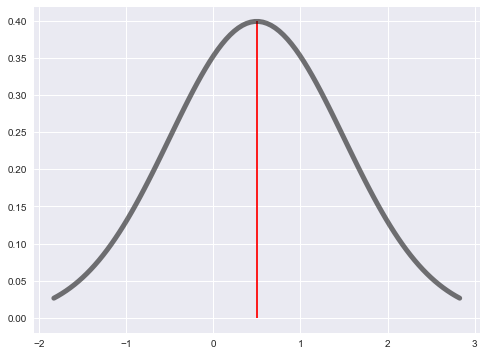

Skewed-normal Distribution | E[X] = 0.5


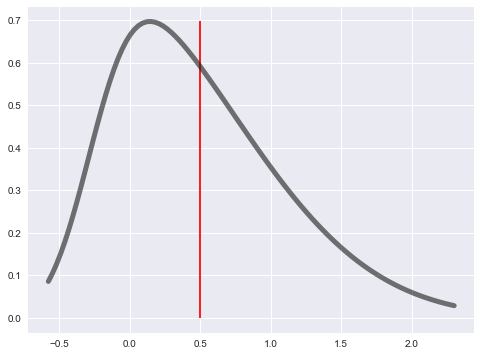

Beta Distribution | E[X]= 0.5


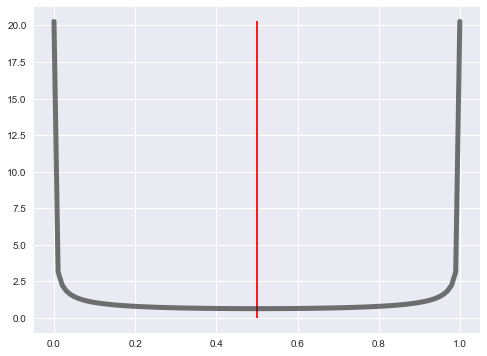

Beta Distribution | E[X] = 0.5


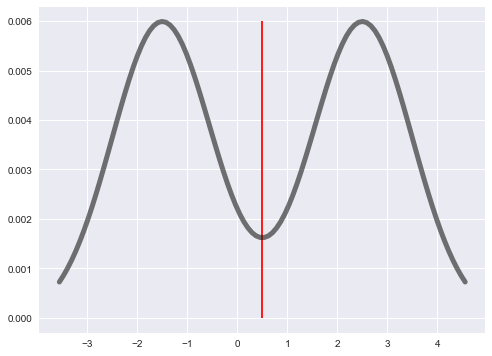

In [11]:
# norm 
mu = 0.5
sigma = 1
models[0] = lambda x: norm.ppf(x, loc=mu, scale=sigma)

x = np.linspace(models[0](0.01), models[0](0.99), 100)
y = norm.pdf(x, loc=mu, scale=sigma)
ax.legend()
plt.plot(x, y, 'k-', lw=5, alpha=0.6, label='Normal pdf')
plt.vlines(x=norm.mean(loc=mu, scale=sigma), ymin=0, ymax=max(y), color='red')
print("Normal Distribution | E[X] =", norm.mean(loc=mu, scale=sigma))
plt.show()

# skewednorm
mu = 0.5-0.774061722645
sigma = 1
alpha = 4
models[1] = prepare_skewnorm_quantile(mu, sigma, alpha)  # skewed-normal distribution model

x = np.linspace(models[1](0.01), models[1](0.99), 100)
y = skewnorm.pdf(x, a=alpha, loc=mu, scale=sigma)
plt.plot(x, y, 'k-', lw=5, alpha=0.6, label='Skewed-normal pdf')
plt.vlines(x=skewnorm.mean(a=alpha, loc=mu, scale=sigma), ymin=0, ymax=max(y), color='red')
print("Skewed-normal Distribution | E[X] =", skewnorm.mean(a=alpha, loc=mu, scale=sigma))
plt.show()

# beta
mu = 0
sigma = 1
a = 0.5
b = 0.5
models[2] = lambda x: beta.ppf(x, a=b, b=b, loc=mu, scale=sigma)

x = np.linspace(models[2](0.01), models[2](0.99), 100)
y = beta.pdf(x, a=a, b=b, loc=mu, scale=sigma)
plt.plot(x, beta.pdf(x, a=a, b=b), 'k-', lw=5, alpha=0.6, label='Beta pdf')
plt.vlines(x=beta.mean(a=a, b=b, loc=mu, scale=sigma), ymin=0, ymax=max(y), color='red')
print(r"Beta Distribution | E[X]=", beta.mean(a=a, b=b, loc=mu, scale=sigma))
plt.show()

# binomial
mu1 = 2.5
mu2 = -1.5
sigma1 = 1
sigma2 = 1
coef1=0.5

binorm = Bimodal_norm(mu1=mu1, sigma1=sigma1, coef1=coef1, mu2=mu2, sigma2=sigma2)
models[3] = lambda x: binorm.ppf(x)

x = np.linspace(models[3](0.01), models[3](0.99), 100)
y = binorm.pdf(x)
plt.plot(x, binorm.pdf(x), 'k-', lw=5, alpha=0.6, label='Beta pdf')
plt.vlines(x=binorm.mean, ymin=0, ymax=max(y), color='red', label="mean")
print("Beta Distribution | E[X] =", binorm.mean)
plt.show()

Then four different distribution functions are compared to each other.

In [12]:
x = np.array([2*i for i in range(1, 50)])
y = np.array([count_significance_frequency_2(n, models[0], models[1]) for n in x])

x1 = np.array([2*i for i in range(1, 50)])
y1 = np.array([count_significance_frequency_2(n, models[0], models[2]) for n in x])

x2 = np.array([2*i for i in range(1, 50)])
y2 = np.array([count_significance_frequency_2(n, models[0], models[3]) for n in x])

x3 = np.array([2*i for i in range(1, 50)])
y3 = np.array([count_significance_frequency_2(n, models[1], models[2]) for n in x])

x4 = np.array([2*i for i in range(1, 50)])
y4 = np.array([count_significance_frequency_2(n, models[1], models[3]) for n in x])

x5 = np.array([2*i for i in range(1, 50)])
y5 = np.array([count_significance_frequency_2(n, models[2], models[3]) for n in x])

The first graph shows the entire scale of percentages from zero to one hundred. On the second scale, it is reduced from zero to ten.

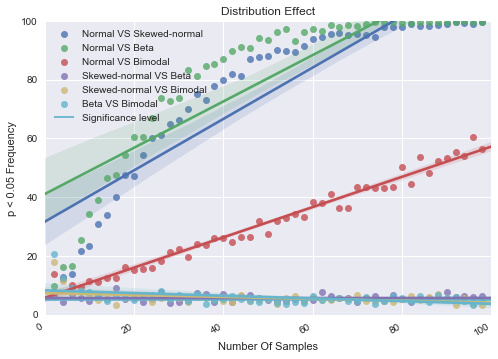

In [13]:
ax = sns.regplot(x, y, label="Normal VS Skewed-normal")
ax1 = sns.regplot(x1, y1, label="Normal VS Beta")
ax2 = sns.regplot(x2, y2, label="Normal VS Bimodal")
ax3 = sns.regplot(x3, y3, label="Skewed-normal VS Beta")
ax4 = sns.regplot(x4, y4, label="Skewed-normal VS Bimodal")
ax5 = sns.regplot(x5, y5, label="Beta VS Bimodal")
ax6 = plt.hlines(y=5, xmin=0, xmax=100, color='red', label="Significance level", linestyles="dotted")

ax.legend()
ax.set_title("Distribution Effect")
ax.set_xlabel("Number Of Samples")
ax.set_ylabel("p < 0.05 Frequency")
plt.axis([0, 100, 0, 100])
plt.gcf().autofmt_xdate()
plt.show()

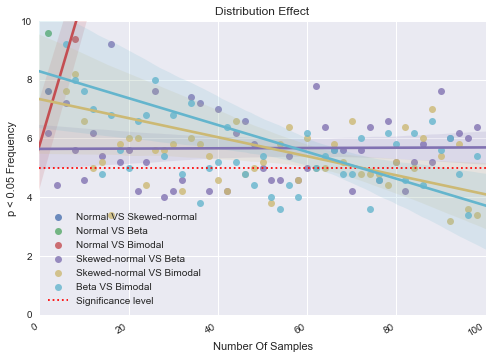

In [16]:
ax = sns.regplot(x, y, label="Normal VS Skewed-normal")
ax1 = sns.regplot(x1, y1, label="Normal VS Beta")
ax2 = sns.regplot(x2, y2, label="Normal VS Bimodal")
ax3 = sns.regplot(x3, y3, label="Skewed-normal VS Beta")
ax4 = sns.regplot(x4, y4, label="Skewed-normal VS Bimodal")
ax5 = sns.regplot(x5, y5, label="Beta VS Bimodal")
ax6 = plt.hlines(y=5, xmin=0, xmax=100, color='red', label="Significance level", linestyles="dotted")

ax.legend()
ax.set_title("Distribution Effect")
ax.set_xlabel("Number Of Samples")
ax.set_ylabel("p < 0.05 Frequency")
plt.axis([0, 100, 0, 10])
plt.gcf().autofmt_xdate()
plt.show()